# Module Control Work (MKR) 2
### Шевченко Юлія, ФІ-31мн

In this homework we are going to rectify a document image that suffers from severe distortion. We will be using the same image and the same detected corners from the previous part of $MKR$.

Remember, OpenCV documentation is your friend ;-)

At the end of this notebook, there are a couple of questions for you to answer.

In [1]:
# All the imports for the task
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image we will be working on in this homework.

(<Axes: >, <matplotlib.image.AxesImage at 0x204e66e4e50>)

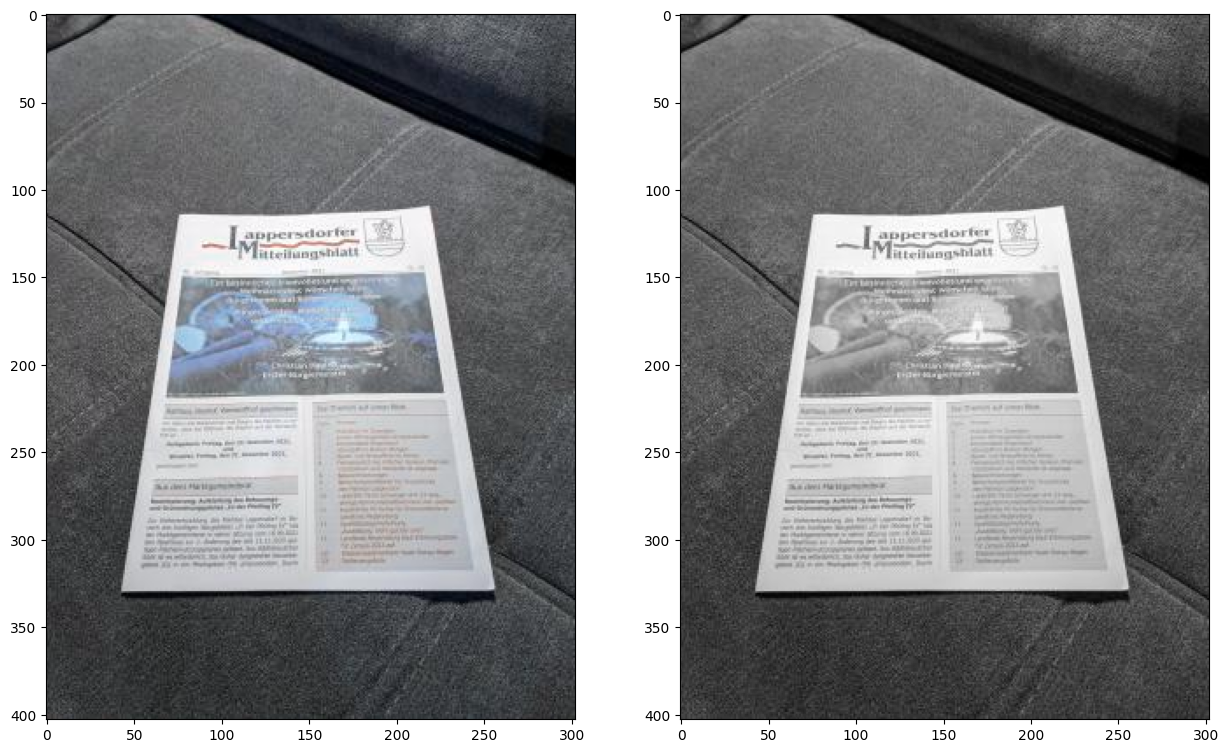

In [3]:
img = cv2.imread('document.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the image
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

In the previous homework you should have detected the four document corners, and you will need to use them here. But don't worry if the previous homework did not work out for you, I am going to provide you with the corners coordinates here :-)

In [4]:
top_left = [76, 115]
top_right = [219, 111]
bottom_left = [43, 330]
bottom_right = [256, 329]

(<Axes: >, <matplotlib.image.AxesImage at 0x204ea19eb10>)

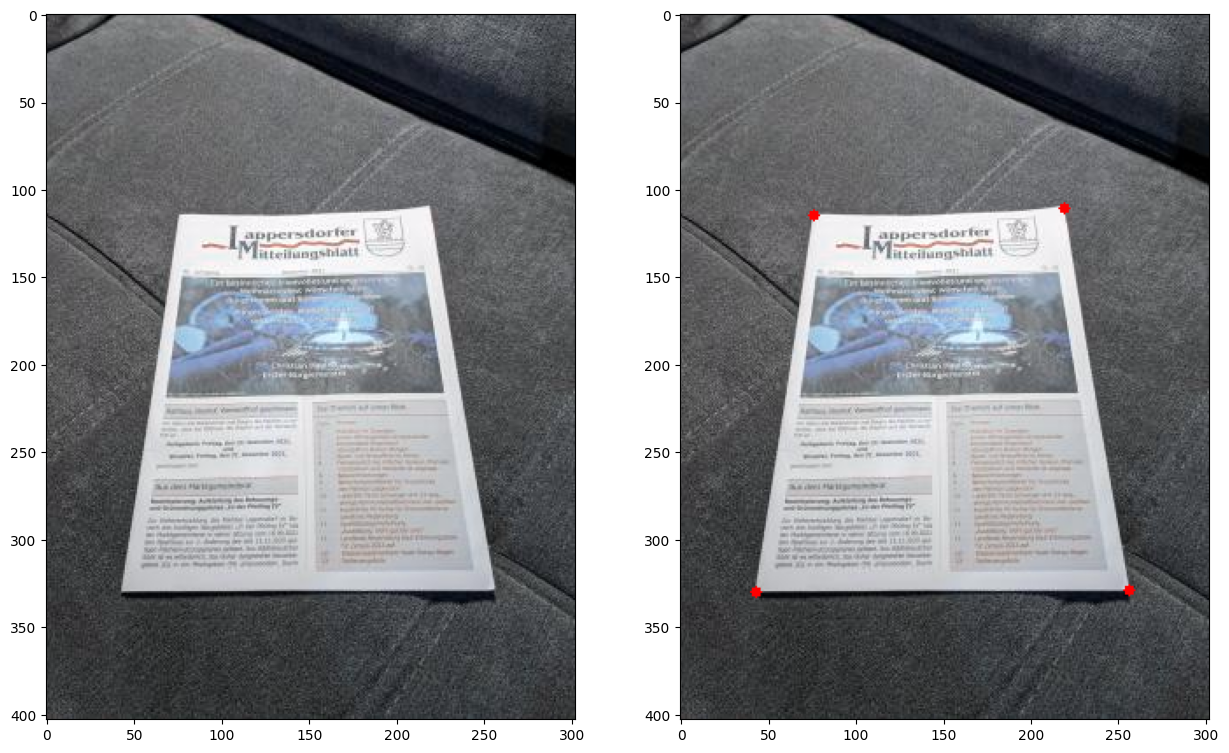

In [5]:
# Let's plot the points
out = np.copy(img)
out = cv2.circle(out, tuple(top_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(top_right), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_left), 3, (255,0,0), -1)
out = cv2.circle(out, tuple(bottom_right), 3, (255,0,0), -1)

plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(out)

### Document Rectification

Let's now try to rectify the document. The goal is to bring the four document corners to the image corners. For instance, we want the top-left document corner to become (0, 0), i.e., the top-left corner of the image itself. In that way, we will fill the complete image with document information, and we will throw away parts of the images that correspond to background (which are of no use to us).

In [6]:
# Define the matrix of source points corresponding to the 4 document corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
src = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)


# Define the matrix of target (destination) points corresponding to the 4 image corners.
# The matrix shall have shape (4, 2), i.e., 4 corners x 2 coordinates
# Note: You will need to explicitly use float32 data type
# Note2: The order of points in src and dst must be the same
dst = np.array([[0, 0], [0, 400], [300, 0], [300, 400]], dtype=np.float32)

transformation_matrix = cv2.getPerspectiveTransform(src, dst)

Let's first start with the affine transform for document rectification. The affine transform can be analytically calculated using 3 point pairs. Therefore, let's select the **first 3 points** and calculate the corresponding transform. We will then use the transform to rectify the document.

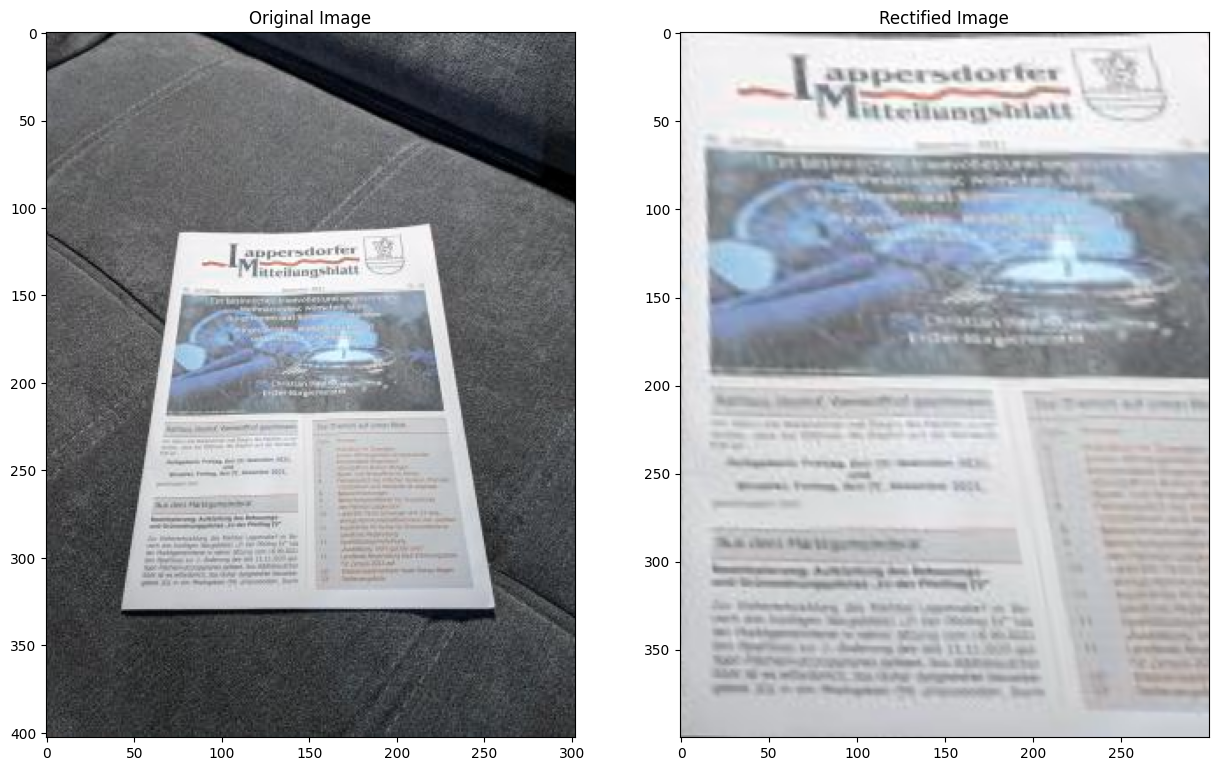

In [7]:
# Compute the affine transform matrix (you'll have to use getAffineTransform function from OpenCV here)
# Use the first 3 points from your src and dst matrix
src = np.array([top_left, top_right, bottom_left], dtype=np.float32)

# Define target points (image corners)
# These points correspond to the corners of the output image
dst = np.array([[0, 0], [300, 0], [0, 400]], dtype=np.float32)

# Compute the affine transformation matrix
M = cv2.getAffineTransform(src[:3], dst[:3])

# Build the rectified image using the computed matrix
rectified = cv2.warpAffine(img, M, (300, 400))

# Plot the results
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(rectified), plt.title('Rectified Image')
plt.show()

Well, this is not bad by certainly not what we were aiming for. Let's try the **last 3** points instead.

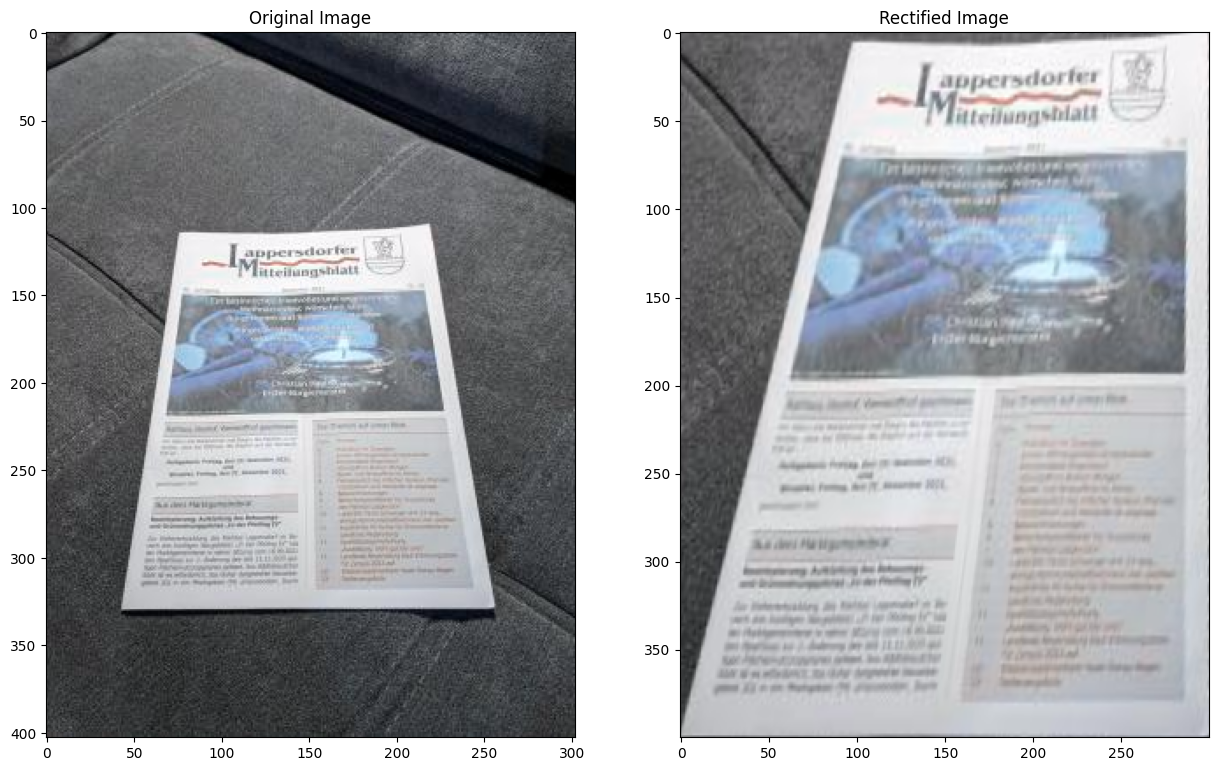

In [8]:
# Define source points (document corners)
src = np.array([top_right, bottom_left, bottom_right], dtype=np.float32)

# Define target points (image corners)
# These points correspond to the corners of the output image
dst = np.array([[300, 0], [0, 400], [300, 400]], dtype=np.float32)

# Compute the affine transformation matrix
M = cv2.getAffineTransform(src[-3:], dst[-3:])

# Build the rectified image using the computed matrix
rectified = cv2.warpAffine(img, M, (300, 400))

# Plot the results
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(rectified), plt.title('Rectified Image')
plt.show()

The result looks different but not better. This approach doesn't seem to be helping then. Let's use **all 4 points** and let OpenCV **estimate** (remember that 4 points are too many for an analytical solution) the best fitting affine transform for us. It'll internally apply optimization approaches as well as RANSAC.

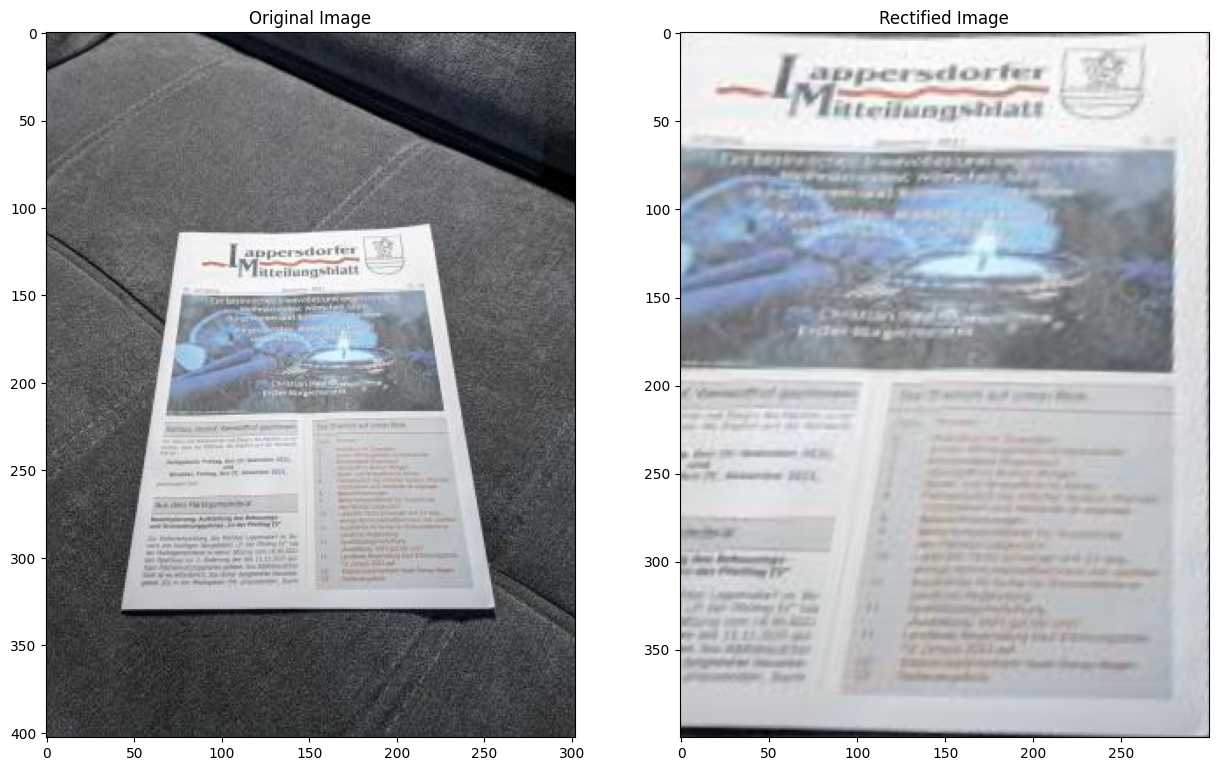

In [9]:
# Estimate the optimal affine transform matrix (you'll have to use estimateAffine2D function from OpenCV here)
# estimateAffine2D it returns the best fitting affine matrix as well as the vector of inliers (1 -> inlier,
# 0 -> outlier).
src = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)

dst = np.array([[0, 0], [300, 0], [0, 400], [300, 400]], dtype=np.float32)

# Compute the affine transformation matrix using OpenCV's estimateAffine2D
M, _ = cv2.estimateAffine2D(src, dst)

# Build the rectified image using the computed matrix
rectified = cv2.warpAffine(img, M, (300, 400))

# Plot the results
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(rectified), plt.title('Rectified Image')
plt.show()

There is not much of an improvement either. Let's try homography instead of affine transform. Remember that for computing the homography analytically we need to use 4 pairs of points.

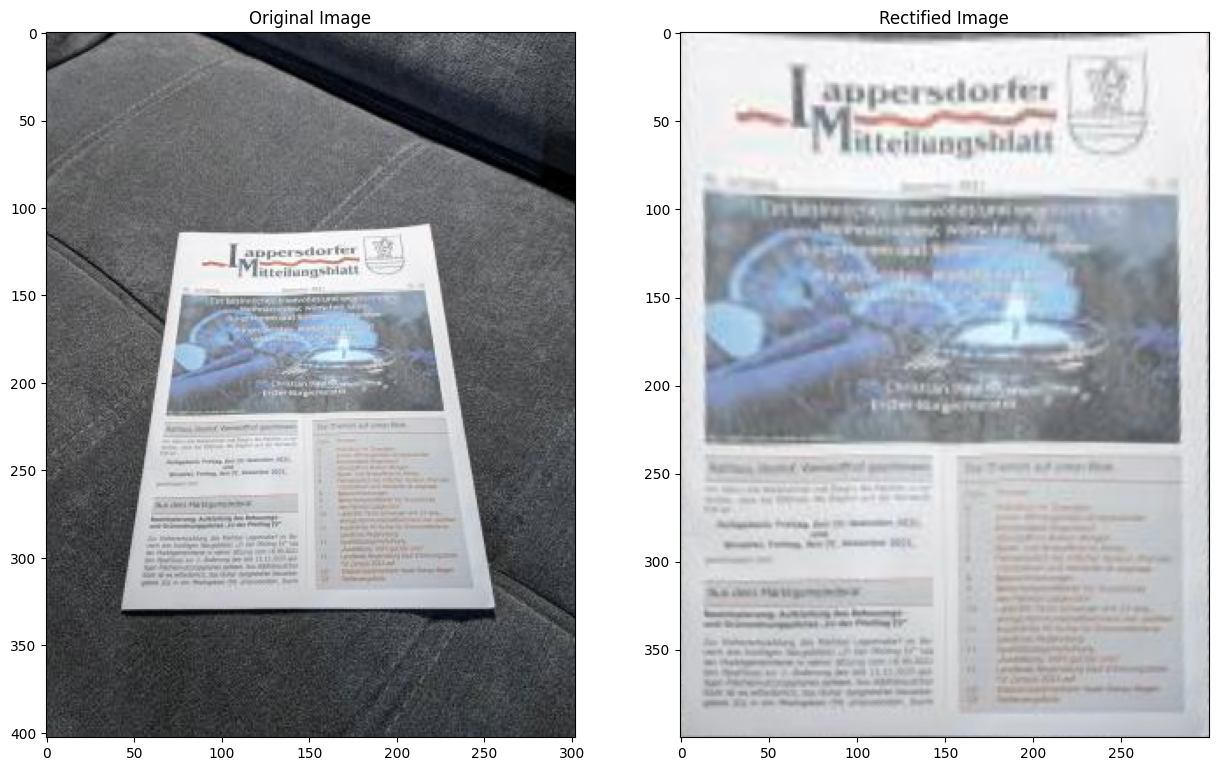

In [10]:
src = np.array([top_left, top_right, bottom_left, bottom_right], dtype=np.float32)

dst = np.array([[0, 0], [300, 0], [0, 400], [300, 400]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)

rectified = cv2.warpPerspective(img, M, (300, 400))

# Plot the results
plt.subplot(121), plt.imshow(img), plt.title('Original Image')
plt.subplot(122), plt.imshow(rectified), plt.title('Rectified Image')
plt.show()

### Questions & Answers

**Q1: The affine transform does not seem to be working well in this case. Why?**

**A:** Affine transformation, which assumes a linear relationship between corresponding points, struggles in scenarios where documents exhibit perspective distortions or non-linear transformations. This method is limited to handling basic translations, rotations, and scalings. However, when documents are viewed at angles or have uneven alignments, affine transformation fails to accurately correct these distortions. Selecting precise points for transformation calculation is crucial, as inaccuracies in point selection lead to ineffective alignment of document corners with target coordinates.

* * * * *

**Q2: What can you tell me about the values you have obtained for the inliers vector? What does it mean?**

**A:** In computer vision, the inliers vector determines which points from the source and destination sets are used to calculate geometric transformations like affine or homography. A value of `1` signifies an inlier, indicating that the point fits well with the estimated model and contributes significantly to transformation accuracy. Conversely, a value of `0` denotes an outlier that does not align well with the transformation model. High inlier values indicate strong geometric consistency among selected points, ensuring precise mapping from source to target points. This metric is essential for evaluating the reliability of transformations in applications such as document rectification, where accurate alignment of document corners with specified coordinates is critical for subsequent processing.

* * * * *

**Q3: How does the result from homography look? Does it work well enough?**

**A:** Homography, unlike affine transformation, offers greater flexibility in correcting complex distortions such as perspective changes, skewness, and non-linear transformations. It calculates a transformation matrix that best fits the correspondence between multiple points, thereby providing a more accurate rectification of documents viewed at various angles or with perspective distortion. Visually evaluating the homography result shows a natural alignment of document corners with target coordinates, effectively removing perspective distortions and presenting a top-down view of the document. This approach ensures that rectified images closely resemble the intended alignment without visible skewness or distortion, demonstrating the effectiveness of homography in tasks requiring precise document alignment for further analysis or processing.